In [2]:
import csv
import math
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torchsummary
import matplotlib.pyplot as plt
from src.plot_utils import draw_pitch
from torchsummary import summary
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

#### Checking torch environment 

In [3]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

In [4]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:2.0.1
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-13.4-arm64-arm-64bit


#### 커스텀 데이터셋 구성

In [5]:
class custom_dataset(Dataset):
    def __init__(self, file_path):
        data = pd.read_csv(file_path)
        data['Ball_x'] = data['Ball_x']/104
        data['loc_x'] = data['loc_x']/104
        data['Ball_y'] = data['Ball_y']/68
        data['loc_y'] = data['loc_y']/68
        self.columns = data.columns.to_list()
        self.y = data['v_kl'].values.reshape(-1, 1)
        self.x = data[['Ball_x', 'Ball_y', 'loc_x', 'loc_y']].values
        self.length = len(data)
    
    def __getitem__(self, index):
        x = torch.FloatTensor(self.x[index])
        y = torch.FloatTensor(self.y[index])
        return x, y
    
    def __len__(self):
        return self.length
    
    def column(self):
        return self.column

In [6]:
dataset = custom_dataset('./Data/full_data2.csv')

In [7]:
dataset_size = len(dataset)
print(dataset_size)

691488


In [8]:
train_size = int(dataset_size * 0.8)
test_size = dataset_size - train_size

In [9]:
generator1 = torch.Generator().manual_seed(1)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024)

In [12]:
class nnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(4, 24, bias=True)
        self.hidden2 = nn.Linear(24, 16, bias= True)
        self.hidden3 = nn.Linear(16, 8, bias= True)
        self.output = nn.Linear(8, 1, bias=True)
        #self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.output(x)

        return x
    
    def reset_parameters(self):
        nn.init.kaiming_normal_(self.hidden1.weight)
        self.hidden1.bias.data.fill_(0.01)
        nn.init.kaiming_normal_(self.hidden2.weight)
        self.hidden2.bias.data.fill_(0.01)
        nn.init.kaiming_normal_(self.hidden3.weight)
        self.hidden3.bias.data.fill_(0.01)
        nn.init.kaiming_normal_(self.output.weight)
        self.output.bias.data.fill_(0.01)

In [37]:
model = nnModel()
model.reset_parameters()

In [38]:
summary(model, (128, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 128, 24]             120
            Linear-2              [-1, 128, 16]             400
            Linear-3               [-1, 128, 8]             136
            Linear-4               [-1, 128, 1]               9
Total params: 665
Trainable params: 665
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [39]:
model.to(device=device)

nnModel(
  (hidden1): Linear(in_features=4, out_features=24, bias=True)
  (hidden2): Linear(in_features=24, out_features=16, bias=True)
  (hidden3): Linear(in_features=16, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)

In [40]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

# loss function
loss_fn = nn.MSELoss()

# training
train_loss_list=[]
test_loss_list=[]

n = len(train_dataloader)



epoch = 150
for i in range(epoch):
    model.train()
    train_loss = 0

    #load data
    for idx, data in enumerate(train_dataloader):
        x, y = data
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        #forward propagation
        y_pred = model(x)
        loss = loss_fn(y_pred,y)
        
        #backpropagation
        loss.backward()
        optimizer.step()

        train_loss += loss.mean()
        print('\r {}/{} batch_loss : {:.8f}'.format(idx, n, loss.mean()), end="")
    
    train_loss /= n
    train_loss_list.append(train_loss.item())

    print('\n epoch {}/{} train_loss : {:.8f}'.format(i+1, epoch, train_loss))

    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)
            
            y_pred = model(x)
            loss = loss_fn(y_pred,y)
            
            test_loss += loss.mean()

        test_loss /= len(test_dataloader)
        test_loss_list.append(test_loss.item())

        print('epoch {}/{} test_loss : {:.8f} \n'.format(i+1, epoch, test_loss))

        if min(test_loss_list) >= test_loss.item():
            torch.save(model.state_dict(), './SpaceValueModel/best_svmodel_sdict.pt')

 540/541 batch_loss : 0.08280817
 epoch 1/150 train_loss : 0.31742111
epoch 1/150 test_loss : 0.08858337 

 540/541 batch_loss : 0.06871308
 epoch 2/150 train_loss : 0.08175839
epoch 2/150 test_loss : 0.07656022 

 540/541 batch_loss : 0.06804448
 epoch 3/150 train_loss : 0.07394415
epoch 3/150 test_loss : 0.07117728 

 540/541 batch_loss : 0.05188702
 epoch 4/150 train_loss : 0.06907862
epoch 4/150 test_loss : 0.06786592 

 540/541 batch_loss : 0.06547178
 epoch 5/150 train_loss : 0.06703955
epoch 5/150 test_loss : 0.06652960 

 540/541 batch_loss : 0.07043460
 epoch 6/150 train_loss : 0.06602032
epoch 6/150 test_loss : 0.06553061 

 540/541 batch_loss : 0.08248743
 epoch 7/150 train_loss : 0.06532957
epoch 7/150 test_loss : 0.06497330 

 540/541 batch_loss : 0.05486256
 epoch 8/150 train_loss : 0.06466173
epoch 8/150 test_loss : 0.06428479 

 540/541 batch_loss : 0.06082789
 epoch 9/150 train_loss : 0.06403147
epoch 9/150 test_loss : 0.06372009 

 540/541 batch_loss : 0.06267575
 epo

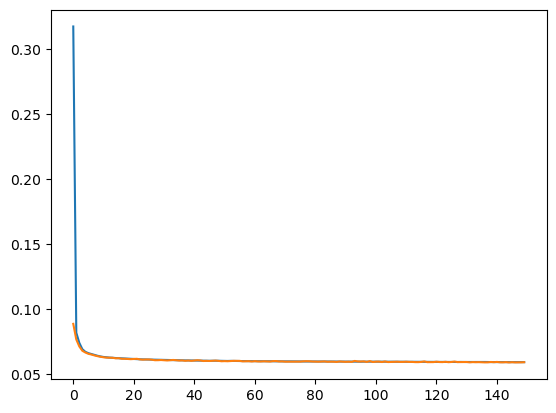

In [42]:
plt.plot(train_loss_list)
plt.plot(test_loss_list)

In [43]:
model.to('cpu')

nnModel(
  (hidden1): Linear(in_features=4, out_features=24, bias=True)
  (hidden2): Linear(in_features=24, out_features=16, bias=True)
  (hidden3): Linear(in_features=16, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)

In [44]:
nn_model = nnModel()

In [45]:
nn_model.load_state_dict(torch.load('./SpaceValueModel/best_svmodel_sdict.pt'))

<All keys matched successfully>

(0.0, 1.0)

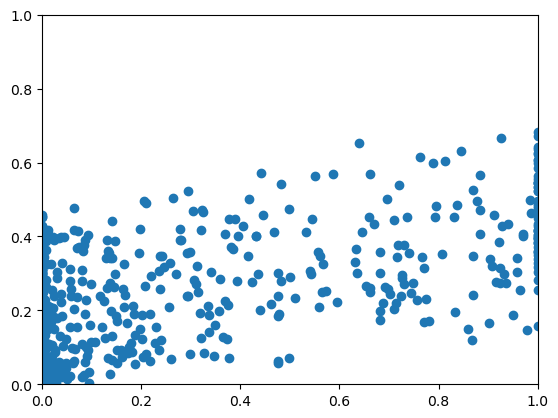

In [46]:
plt.scatter(test_dataset.dataset.y[0:1000], nn_model(torch.Tensor(test_dataset.dataset.x[0:1000])).detach().numpy())
plt.xlim((0, 1))
plt.ylim((0, 1))


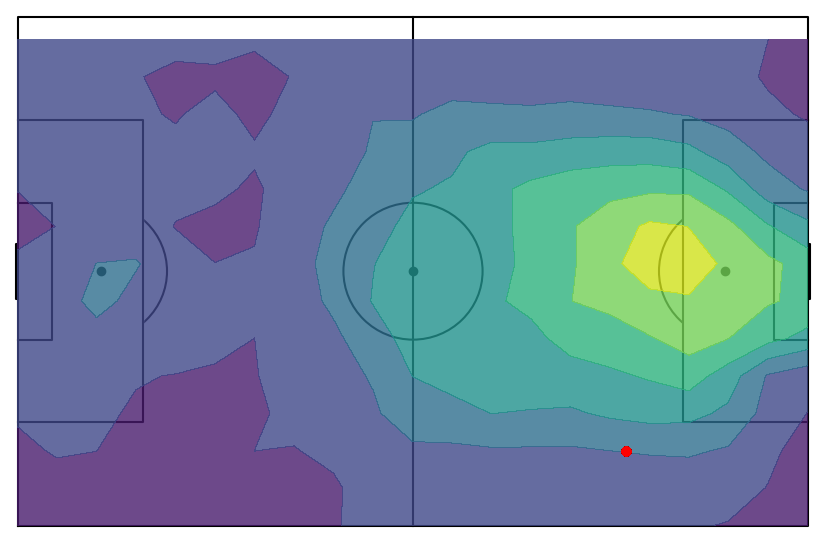

In [49]:
x, y = np.mgrid[0:104:5, 0:68:5]
x = x.reshape(-1, 1) /104
y = y.reshape(-1, 1) /68
ball_x = 80 * np.ones_like(x) / 104
ball_y = 10 * np.ones_like(y) / 68

input = torch.FloatTensor(np.concatenate([ball_x, ball_y, x, y], axis=1))
output = model(input)
output = output.detach().numpy()
fig, ax = draw_pitch('white', 'black')
ax.contourf(x.reshape(21, 14)*108, y.reshape(21, 14)*68, output.reshape(21, 14), alpha=0.8)
ax.scatter(ball_x*104, ball_y*68, c='red')

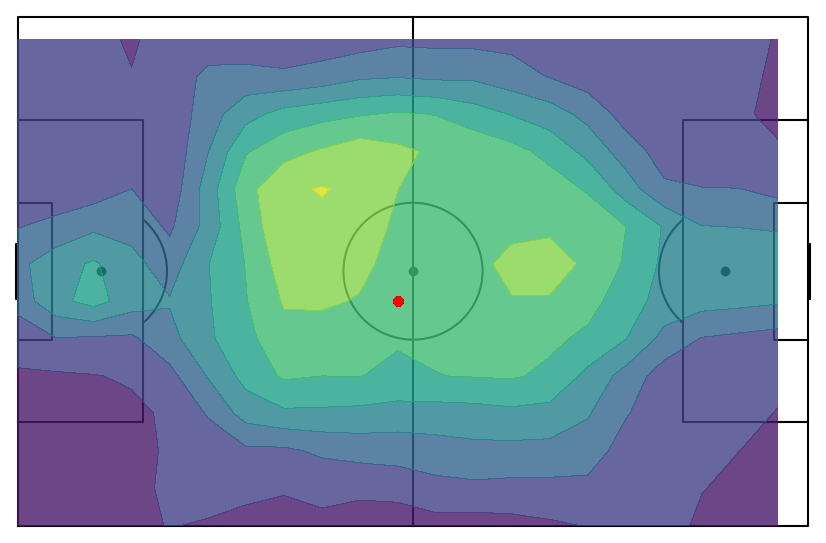

In [86]:
x, y = np.mgrid[0:104:5, 0:68:5]
x = x.reshape(-1, 1) /104
y = y.reshape(-1, 1) /68
ball_x = 50 * np.ones_like(x) / 104
ball_y = 30 * np.ones_like(y) / 68

input = torch.FloatTensor(np.concatenate([ball_x, ball_y, x, y], axis=1))
output = model(input)
output = output.detach().numpy()
fig, ax = draw_pitch('white', 'black')
ax.contourf(x.reshape(21, 14)*104, y.reshape(21, 14)*68, output.reshape(21, 14), alpha=0.8)
ax.scatter(ball_x*104, ball_y*68, c='red')

In [155]:
x, y = np.mgrid[0:104:2, 0:68:2]
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

def distance_from_goal(x, y):
    dist = np.sqrt((104-x)**2 + (34-y)**2)
    max_v = np.max(dist)
    return (max_v - dist+100)/ (max_v+100)

z = distance_from_goal(x, y)


In [156]:
z.shape

(1768, 1)

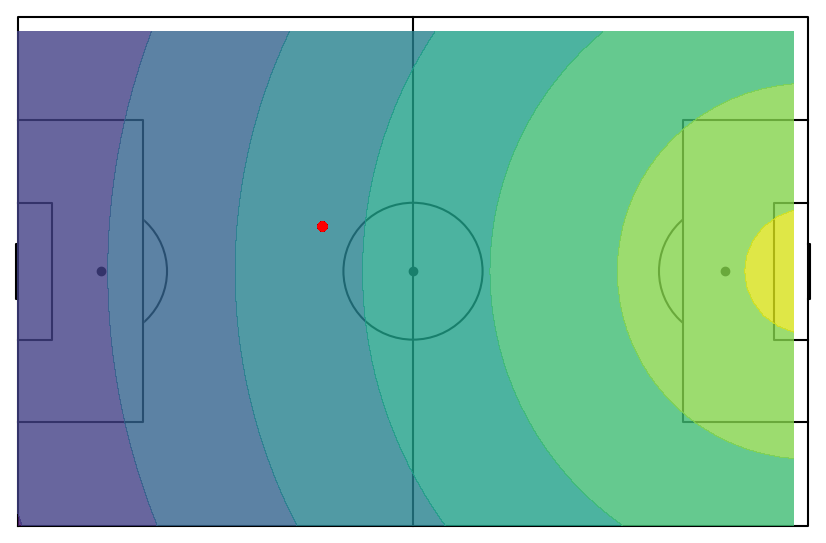

In [157]:
fig, ax = draw_pitch('white', 'black')
ax.contourf(x.reshape(52, 34), y.reshape(52, 34), z.reshape(52, 34), alpha=0.8)
ax.scatter(ball_x*104, ball_y*68, c='red')

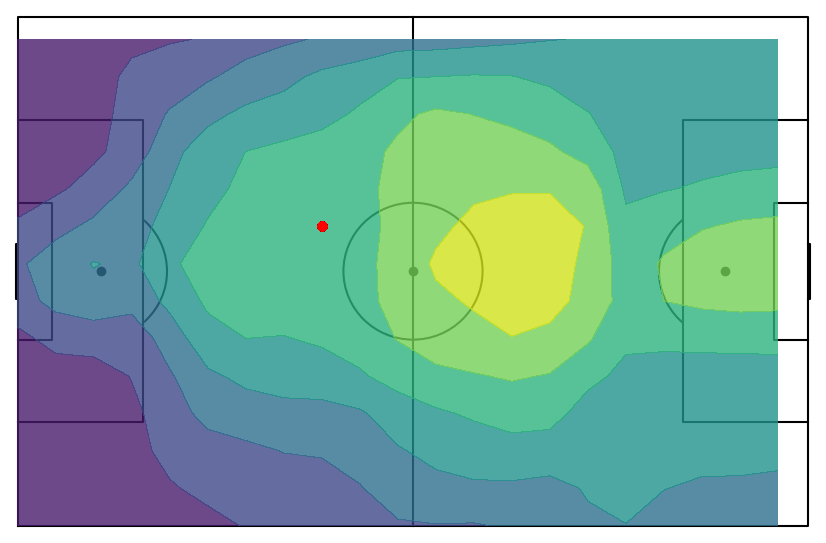

In [158]:
ball_x = 40
ball_y = 40

#################################
x, y = np.mgrid[0:104:5, 0:68:5]
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
z = distance_from_goal(x, y)
x = x/104
y = y/68 
ball_x = ball_x * np.ones_like(x) / 104
ball_y = ball_y * np.ones_like(y) / 68

input = torch.FloatTensor(np.concatenate([ball_x, ball_y, x, y], axis=1))
output = model(input)
output = output.detach().numpy()
output += z
output = (output - min(output))/ (max(output) - min(output))
fig, ax = draw_pitch('white', 'black')
ax.contourf(x.reshape(21, 14)*104, y.reshape(21, 14)*68, output.reshape(21, 14), alpha=0.8)
ax.scatter(ball_x*104, ball_y*68, c='red')